Universidade do Vale do Itajaí<br>
Escola do Mar, Ciência e Tecnologia<br>
Engenharia de Computação - Processamento Digital de Sinais: Imagens

# Exercício Avalitivo de Redes Neurais Convolucionais

### Tutoriais da OpenCV

- https://docs.opencv.org/master/d9/df8/tutorial_root.html
- https://www.geeksforgeeks.org/opencv-python-tutorial/
- https://www.tensorflow.org/learn?hl=pt-br   

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from skimage.util import random_noise
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#abria a imagem
img = cv2.imread('data/t1.jpg',1)
#cv2_imshow(img)

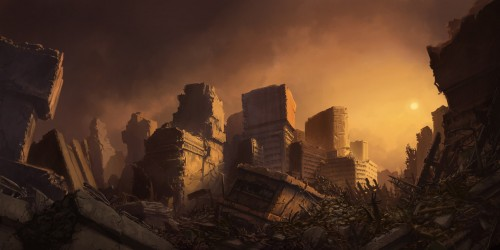

In [ ]:
#mostrando a imagem colorida
cv2_imshow(img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

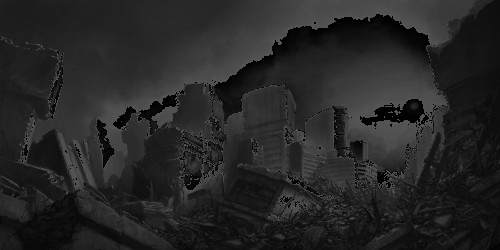

In [ ]:
#aplicando conversão básica
#numpy
#img_grayscale_basic = (img[ : , : ,0]+img[ : , : ,1]+img[ : , : ,2])/3

#cv2
B, G, R = cv2.split(img)
img_grayscale_basic = (B+G+R)/3

img_grayscale_basic = np.array(img_grayscale_basic, dtype=np.uint8)

cv2_imshow(img_grayscale_basic)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [2]:
print('Python version:', sys.version.split(' ')[0])

print('TensorFlow version:', tf.__version__)

# Find out NVIDIA GPU model (randomly assigned by Colab)
# Deep learning performance: K80 < P4 < T4 < P100
# https://ai-benchmark.com/ranking_deeplearning.html
gpu = !nvidia-smi -L
gpu = gpu[0].split(' (')[0]
if 'failed' in gpu:
  print('GPU: None')
else:
  print(gpu, '\n')
  # GPU information
  !nvidia-smi

Python version: 3.7.14
TensorFlow version: 2.8.2
GPU 0: Tesla T4 

Thu Oct  6 00:01:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                     

In [3]:
def plots(history):
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], '.-', label='Train loss')
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'], '.-', label='Val loss')
    plt.xlabel('Epochs');
    plt.legend();
    plt.grid();
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
    plt.xlabel('Epochs');
    if 'val_accuracy' in history.history.keys():
        plt.plot(history.history['val_accuracy'], '.-', label='Val accuracy')
        plt.legend();
        plt.grid();

## CNN


### Dataset

1. Faça o download do dataset:
  - Opção 1: https://www.tensorflow.org/datasets/catalog/cifar10_corrupted?hl=pt-br (uma das opções de corrompimento).
  - Opção 2: https://www.tensorflow.org/datasets/catalog/rock_paper_scissors?hl=pt-br.
  - Opção 3: https://www.tensorflow.org/datasets/catalog/beans?hl=pt-br 
  - Opção 4: https://www.tensorflow.org/datasets/catalog/malaria?hl=pt-br 
  - Opção 5: https://www.tensorflow.org/datasets/catalog/eurosat?hl=pt-br
2. Adicione ruído do tipo salt and pepper, branco ou gaussino. Caso escolha a Opção 1, não é necessário aplicar ruído.
3. Dimensione o dataset para uma quantidade adequada de imagens que seja possível treinar e testar (principalmente se você usa o Colab free). Porém, cuidado com um quantidade muito pequena que não possibilite uma boa generalização de amostras.
4. Faça o split do dataset em uma quantidade adequada para treinamento, validação e teste. É extremamente desejavel um nível bom de aleatoriedade ao fazer o split dos dados.


In [4]:
ds, ds_info = tfds.load(name = 'beans', with_info=True,as_supervised=True)  

train_ds = ds['train']
validation_ds = ds['validation']
test_ds = ds['test']

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 1034
Number of validation samples: 133
Number of test samples: 128


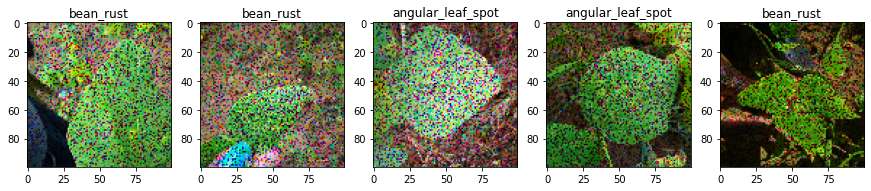

In [19]:
def plot_dataset(dataset, num=5):  
  plt.figure(figsize=(15, 15))  
  plot_index = 0  

  for image, label in dataset.take(num):  
    image = image.numpy()  
    label = label.numpy()
    image_label = ds_info.features['label'].int2str(label)
    plot_index += 1  
    plt.subplot(3, 5, plot_index)  
    plt.title(image_label)  
    plt.imshow(image.astype(np.uint8))

def noise_image(image, label, prob_salt = 0.1, prob_pepper = 0.1):
  image = tf.image.resize(image, (100, 100))
  random = tf.random.uniform(shape = image.shape)
  image = tf.where((random < prob_salt), 1.0, image)
  image = tf.where((1 - random) < prob_pepper, 0.0, image)
  return image, label

def resize(image, label):
    image_size = 100
    image = tf.image.resize(image, (image_size, image_size))  
    return image, label

test_ds = test_ds.map(resize)
train_size = ds_info.splits['train'].num_examples 
test_size = ds_info.splits['test'].num_examples

train_ds_noise = train_ds.map(noise_image)
plot_dataset(train_ds_noise, 5)

### Fluxo de Algoritmos

1. Pré-processamento: Com o dataset carregado, avalie as imagens (estado, ruído, informação contida) e adicione algoritmos vistos em aula (operações pontuais, filtragem, morfologia) e pré-processe as imagens para treinamento e predição (com o conjunto de testes). Lembre-se de aplicar o fluxo em todas as imagens.
  - Você deve aplicar pelo menos um algoritmo de filtragem espacial. A sua avaliação indicará qual é necessário.
  - Você deve aplicar pelo menos um algoritmo de operação pontual e/ou morfologia. Lembre-se que a sua avaliação indicará qual é necessário.

2. Processamento: Proponha uma arquitetura de CNN para classificar as imagens geradas pelo pré-processamento. Apresente a arquitetura proposta, acurácia e loss (perda) (treinamento, validação e teste) e quantidade de parâmentros da rede. Faça uma análise do resultados e do fluxo utilizado. Quais as suas conclusões?

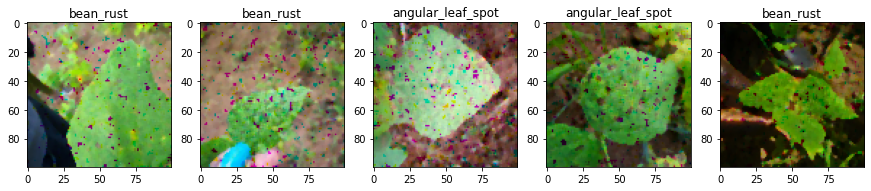

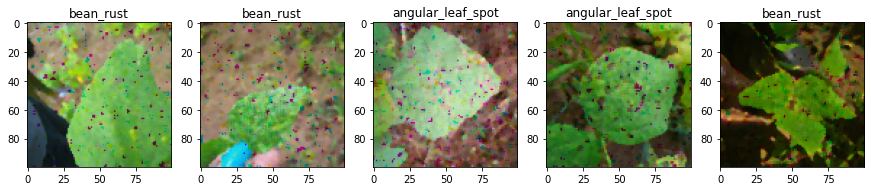

In [20]:
def mediana(image, label):
  image = tfa.image.median_filter2d(image)
  return image, label

def gamma(image, label):
  image = tf.image.adjust_contrast(image, 0.9)
  return image, label

train_ds_mediana = train_ds_noise.map(mediana)
plot_dataset(train_ds_mediana, 5)

train_ds_gamma = train_ds_mediana.map(gamma)
plot_dataset(train_ds_gamma, 5)

In [21]:
batch_size=64
image_size = 100

dataset_train_batches = train_ds_gamma.shuffle(buffer_size=train_size).batch(batch_size=batch_size). prefetch(buffer_size=tf.data.experimental.AUTOTUNE)   
dataset_test_batches = test_ds.batch(batch_size)  
print(dataset_train_batches)   
print(dataset_test_batches) 

model = tf.keras.Sequential([  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=64, kernel_size=3, activation='relu'), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=128, kernel_size=3, activation='relu'),  
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu),  
    tf.keras.layers.Dense(units=ds_info.features['label'].num_classes  , activation=tf.keras.activations.softmax)  
]) 

model.summary()

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 dropout_10 (Dropout)        (None, 98, 98, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
             

In [26]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)  

model.compile(optimizer=rmsprop_optimizer,  
              loss='sparse_categorical_crossentropy',                 
              metrics=['accuracy'])  

steps_per_epoch = train_size // batch_size  
validation_steps = test_size // batch_size  

print('steps_per_epoch:', steps_per_epoch)  
print('validation_steps:', validation_steps)  
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy') 

training_history = model.fit(x=dataset_train_batches.repeat(),  
                    validation_data=dataset_test_batches.repeat(), 
                    epochs=10,   
                    steps_per_epoch=steps_per_epoch,  
                    validation_steps=validation_steps,  
                    callbacks=[early_stopping],  
                    verbose=1) 

steps_per_epoch: 16
validation_steps: 2
Epoch 1/10
16/16 [==============================] - 14s 101ms/step - loss: 1.2496 - accuracy: 0.5840 - val_loss: 0.9557 - val_accuracy: 0.6484
Epoch 2/10
16/16 [==============================] - 13s 858ms/step - loss: 0.7683 - accuracy: 0.6784 - val_loss: 0.8459 - val_accuracy: 0.6562
Epoch 3/10
16/16 [==============================] - 13s 840ms/step - loss: 0.6821 - accuracy: 0.7010 - val_loss: 0.7778 - val_accuracy: 0.6875
Epoch 4/10
16/16 [==============================] - 13s 855ms/step - loss: 0.6903 - accuracy: 0.6990 - val_loss: 0.8241 - val_accuracy: 0.6797
Epoch 5/10
16/16 [==============================] - 13s 888ms/step - loss: 0.6885 - accuracy: 0.6876 - val_loss: 0.7313 - val_accuracy: 0.7656
Epoch 6/10
16/16 [==============================] - 13s 854ms/step - loss: 0.6705 - accuracy: 0.7196 - val_loss: 0.9118 - val_accuracy: 0.7188
Epoch 7/10
16/16 [==============================] - 13s 853ms/step - loss: 0.6600 - accuracy: 0.6979 -

In [27]:
def plot_training_history(training_history):  
    loss = training_history.history['loss']     
    val_loss = training_history.history['val_loss']
    accuracy = training_history.history['accuracy']     
    val_accuracy = training_history.history['val_accuracy']
    plt.figure(figsize=(18, 6))  

    plt.subplot(1, 2, 1)  
    plt.title('Training and Test Loss')  
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')  
    plt.plot(loss, label='Training set')  
    plt.plot(val_loss, label='Test set', linestyle='--')  
    plt.legend()  
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)  
    plt.subplot(1, 2, 2)  
    plt.title('Training and Test Accuracy')  
    plt.xlabel('Epoch')  
    plt.ylabel('Accuracy')  
    plt.plot(accuracy, label='Training set')  
    plt.plot(val_accuracy, label='Test set', linestyle='--')  
    plt.legend()  
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)  
    plt.show() 

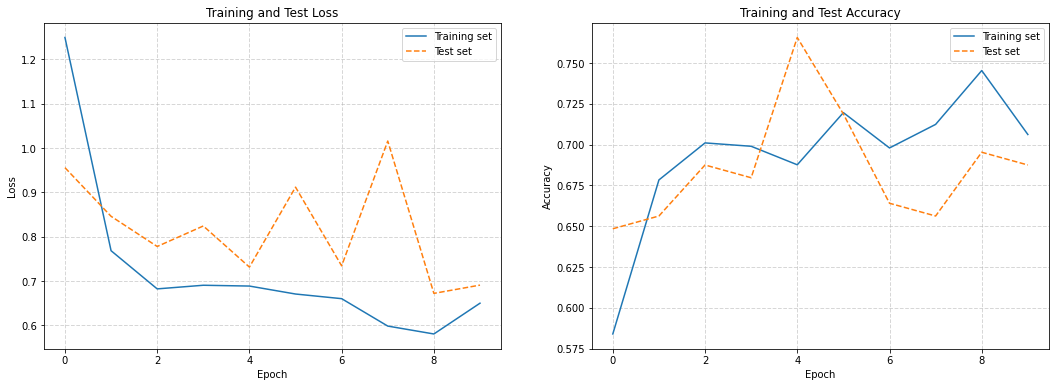

2/2 [==============================] - 0s 38ms/step - loss: 0.6906 - accuracy: 0.6875
Training Loss:  0.7648488879203796
Training Accuracy:  0.6547389030456543
Test Loss:  0.6906375885009766
Test Accuracy:  0.6875


In [30]:
plot_training_history(training_history) 
train_loss, train_accuracy = model.evaluate(train_ds_gamma.batch(batch_size).take(train_size))  
test_loss, test_accuracy = model.evaluate(test_ds.batch(batch_size).take(test_size))  

print('Training Loss: ', train_loss)  
print('Training Accuracy: ', train_accuracy)  
print('Test Loss: ', test_loss)  
print('Test Accuracy: ', test_accuracy)

## Melhorias

1. Propanha alterações no fluxo de pré-processamento e processamento: inserção ou retirada de algoritmos, aumento/diminuição da arquiteura proposta, tunning de hiperparâmetros, data augmentation, etc. Você pode adicionar técnicas além das citadas em aula.

2. Houve melhoria da acurácia? Procure outra métrica da literatura e aplique para avaliar o quão bom é a classificação. Os resultados apresentados pelas duas métricas é ruim/satisfatório/bom/ótimo? Comente e análise os seus resutaldos.

## (OPCIONAL) 

1. Apresente as características importantes extraídas pelas camadas/CNN e aplique alguma pós-processamento (notificação de mensagem, envio de email, etc...). 